In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 
from scipy.spatial import Delaunay
from scipy.cluster.vq import kmeans, vq
import sys
sys.setrecursionlimit(30000000)

In [5]:
def euclidiana(u,v):
    return np.linalg.norm(u-v)

In [6]:
def cs(u,v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [7]:
class Nodo:
    def __init__(self, vectores=None,padre=None, mediana=None, beta=None, unitario=None, prof=0, izq=None, der=None,*,visitado=False):
        self.vectores = vectores
        self.mediana = mediana
        self.beta = beta
        self.unitario = unitario
        self.padre = padre
        self.prof = prof
        self.izq = izq
        self.der = der
        self.visitado = visitado

    def es_hoja(self):
        return self.vectores is not None

In [8]:
def construye_arbol_medianas(base, m0, prof):
    # Aquí escribimos el caso base de la funcion, devolviendo una hoja si se cumple alguna condicion que se especifica en el pseudocódigo proporcionado
    if base.shape[0] <= m0 or base.shape[1] == prof:
        # Se devuelve la clase mayoritaria y la distribución con un diccionario que asocia cada clase al número de elementos que tiene asociada
        return Nodo(vectores=base, prof=prof)
    else:
        coordenada = base[:, prof]
        mediana = np.median(coordenada)
        # Dividimos la base
        base_izq = base[coordenada < mediana]
        base_der = base[coordenada >= mediana]

        # Y hacemos las llamadas recursivas
        A_izq = construye_arbol_medianas(base_izq, m0, prof + 1)
        A_der = construye_arbol_medianas(base_der, m0, prof + 1)

        # Una vez terminadas, devolvemos el nodo con todo lo calculado en la función
        return Nodo(mediana=mediana, prof=prof, izq=A_izq, der=A_der)



In [9]:
def construye_arbol_random(base, m0, prof):
    # Aquí escribimos el caso base de la funcion, devolviendo una hoja si se cumple alguna condicion que se especifica en el pseudocódigo proporcionado
    if base.shape[0] <= m0 or base.shape[1] == prof:
        # Se devuelve la clase mayoritaria y la distribución con un diccionario que asocia cada clase al número de elementos que tiene asociada
        return Nodo(vectores=base, prof=prof)
    else:
        vector = np.random.randn(base.shape[1])
        unitario = vector / np.linalg.norm(vector)
        beta = 100 * (np.random.rand() * (1 / 2)) + 1 / 4
        escalares = np.dot(unitario, base.T)
        proyecciones = escalares / np.linalg.norm(base)
        percentil = np.percentile(proyecciones, beta)
        # Dividimos la base
        base_izq = base[escalares < percentil]
        base_der = base[escalares >= percentil]

        # Y hacemos las llamadas recursivas
        A_izq = construye_arbol_random(base_izq, m0, prof + 1)
        A_der = construye_arbol_random(base_der, m0, prof + 1)

        # Una vez terminadas, devolvemos el nodo con todo lo calculado en la función
        return Nodo(beta=beta, unitario=unitario, prof=prof, izq=A_izq, der=A_der)

In [10]:
def construye_arbol_spill(base, m0, prof, alfa):
    # Aquí escribimos el caso base de la funcion, devolviendo una hoja si se cumple alguna condicion que se especifica en el pseudocódigo proporcionado
    if base.shape[0] <= m0 or base.shape[1] == prof:
        # Se devuelve la clase mayoritaria y la distribución con un diccionario que asocia cada clase al número de elementos que tiene asociada
        return Nodo(vectores=base, prof=prof)
    else:
        vector = np.random.randn(base.shape[1])
        unitario = vector / np.linalg.norm(vector)
        escalares = np.dot(unitario, base.T)
        proyecciones = escalares / np.linalg.norm(base)
        mediana = np.median(proyecciones)
        (izq, der) = (np.percentile(proyecciones, 100*(1/2 - alfa)), np.percentile(proyecciones, 100*(1/2 + alfa)))
        # Dividimos la base
        base_izq = base[proyecciones < der]
        base_der = base[proyecciones >= izq]
        # Y hacemos las llamadas recursivas
        A_izq = construye_arbol_spill(base_izq, m0, prof + 1, alfa)
        A_der = construye_arbol_spill(base_der, m0, prof + 1, alfa)

        # Una vez terminadas, devolvemos el nodo con todo lo calculado en la función
        return Nodo(mediana=mediana, unitario=unitario, prof=prof, izq=A_izq, der=A_der)

In [67]:
class BranchCut:
    def __init__(self, vectors, m0):
        self.m0 = m0
        self.vectors = vectors # en formato array bidimensional de numpy
        # self.kdTree = construye_arbol_medianas(self.vectors, m0, 0)
        # self.betaTree = construye_arbol_random(self.vectors, m0, 0)
        self.spillTree = construye_arbol_spill(self.vectors, m0, 0, 0.2)

    def search(self, query, random=False):
        # nodo = self.kdTree
        # nodo_beta = self.betaTree
        nodo_spill = self.spillTree
        if random:
        #     opcion = input("Escribe el tipo de busqueda que quieras realizar (beta / spill)")
        #     if opcion == "beta":
        #    return self.search_derrotista(query, nodo_beta)
        #     elif opcion == "spill":
                return self.search_derrotista(query, nodo_spill)
        #     else:
        #         return "Opcion de busqueda incorrecta"
        return self.search_kd(query, nodo_beta, [], None,0)

    def search_kd(self, q, nodo, recorrido, opt,m):
        if nodo.es_hoja():
            distancias = [euclidiana(q,v) for v in nodo.vectores]
            if not distancias:
                nodo.visitado = True
                padre = recorrido[-1]
                return self.search_kd(q, padre, recorrido[:-1], opt,m + 1)
            min_local = (nodo.vectores[np.argmin(distancias)], np.min(distancias))
            if opt is None or opt[1] > min_local[1]:
                opt = min_local
            nodo.visitado = True
            padre = recorrido[-1]
            return self.search_kd(q, padre, recorrido[:-1], opt,m + 1)
        else:
            if not nodo.izq.visitado and not nodo.der.visitado:
                recorrido.append(nodo)
                index = nodo.prof
                comprueba_opt = opt is None or np.abs(q[nodo.prof] - nodo.mediana) < opt[1] 
                if comprueba_opt:
                    if (q[index] < nodo.mediana):
                        print(m)
                        return self.search_kd(q, nodo.izq, recorrido, opt,m + 1)
                    else:
                        print(m)
                        return self.search_kd(q, nodo.der, recorrido, opt,m + 1)
                else:
                    nodo.visitado = True
                    padre = recorrido[-1]
                    print(m)
                    return self.search_kd(q, padre, recorrido[:-1], opt, m + 1)
            else:
                if not nodo.izq.visitado and np.abs(q[nodo.prof] - nodo.mediana) < opt[1]:
                    recorrido.append(nodo)
                    print(m)
                    return self.search_kd(q, nodo.izq, recorrido, opt,m + 1)
                elif not nodo.der.visitado and np.abs(q[nodo.prof] - nodo.mediana) < opt[1]:
                    recorrido.append(nodo)
                    print(m)
                    return self.search_kd(q, nodo.der, recorrido, opt,m + 1)
                else:
                    if not recorrido:
                        return opt, m
                    nodo.visitado = True
                    padre = recorrido[-1]
                    print(m)
                    return self.search_kd(q, padre, recorrido[:-1], opt, m + 1)

    def search_derrotista(self, query, nodo):
        if nodo.es_hoja():
            distancias = [euclidiana(query,v) for v in nodo.vectores]
            min_local = (self.vectors[np.argmin(distancias)], np.min(distancias))
            return min_local
        else:
            proyeccion = np.dot(nodo.unitario, query.T) / np.linalg.norm(query)
            if nodo.beta:
                if proyeccion < nodo.beta:
                    return self.search_derrotista(query, nodo.izq)
                else:
                    return self.search_derrotista(query, nodo.der)
            else:
                if proyeccion < nodo.mediana:
                    return self.search_derrotista(query, nodo.izq)
                else:
                    return self.search_derrotista(query, nodo.der)

In [68]:
def imprimir_arbol(nodo, nivel=0):
    if nodo is None:
        return
    print("  " * nivel + f"Nodo (prof: {nodo.prof}, unitario: {nodo.unitario}, vectores: {nodo.vectores}, mediana: {nodo.mediana})")
    imprimir_arbol(nodo.izq, nivel + 1)
    imprimir_arbol(nodo.der, nivel + 1)

In [ ]:
def potencial(base, q):
    mindist = np.argmin([euclidiana(q, b) for b in base])
    return sum([euclidiana(q,b) / mindist for b in base]) / len(base)

In [ ]:
class CoverTree:
    def __init__(self, vector, nivel, hijos = None):
        self.vector = vector
        self.nivel = nivel
        self.hijos = hijos if hijos is not None else []
    
    def igual(self, cover):
        return np.all(self.vector == cover.vector)

def inserta(p, v):
    if euclidiana(p.vector, v) > 2 ** p.nivel:
        while euclidiana(p.vector, v) > 4 ** p.nivel:
            q = p.hijos.pop()
            p_prima = CoverTree(q.vector, q.nivel + 1, [p])
            p = p_prima
        raiz = CoverTree(v, p.nivel + 1)
        raiz.hijos.append(p)
        return raiz
    return insertaAux(p, v)

def insertaAux(p, v):
    for q in p.hijos:
        if euclidiana(q.vector, v) <= 2 ** p.nivel:
            q_prima = insertaAux(q, v)
            p.hijos = [q_prima if x.igual(q) else x for x in p.hijos]
            return p
    x = CoverTree(v, p.nivel - 1, [])
    p.hijos.append(x)
    return p

def maxdist(cover): 
    if len(cover.hijos) > 0:
        return max([euclidiana(cover.vector, h.vector) for h in cover.hijos])  
    else:
        return 0

def buscarVecino(p, q, y = None):
    if y is None: 
        y = p.vector
    for c in sorted(p.hijos, key = lambda t : euclidiana(q, t.vector)):
        if euclidiana(y,q) > euclidiana(y, c.vector) - maxdist(p):
            y = buscarVecino(c, q, y)
    return y

In [ ]:
def buscarVecinoExacto(p, q):
    mejor = p
    stack = [p]
    distancia_mejor = euclidiana(mejor.vector, q)

    while stack:
        nodo = stack.pop()
        dist_nodo = euclidiana(nodo.vector, q)

        if dist_nodo < distancia_mejor:
            mejor = nodo
            distancia_mejor = dist_nodo

        for hijo in nodo.hijos:
            dist_hijo = euclidiana(hijo.vector, q)
            if dist_hijo < distancia_mejor:
                stack.append(hijo)

    return mejor.vector

In [ ]:
def imprimirCover(cover, i = 0):
        print(" " * i + "vector:" + str(cover.vector))
        print(" " * i + "nivel: " + str(cover.nivel))
        print(" " * i + "hijos: " + str([h.vector for h in cover.hijos]))
        for h in cover.hijos:
            imprimirCover(h, i + 1)


In [ ]:
imprimirCover(cover)
all(cover.hijos[0].hijos[0].vector == base[2])

In [88]:
def create_hyperplane_lsh(base, l, L):
    hashes = []
    signo = lambda v, h : np.dot(v, h) / np.abs(np.dot(v, h))
    buckets = [{} for _ in range(L)]
    for _ in range(L):
        hashes.append([])
        for _ in range(l):
            hashes[-1].append(lambda v : signo(v, np.random.rand(base.shape[1])))
    for b in base:
        for i in range(L):
            bk = tuple([hashes[i][j](b) for j in range(l)])
            if bk not in buckets[i].keys():
                buckets[i][bk] = [b]
            else:
                buckets[i][bk].append(b)
    return hashes, buckets


In [ ]:
def cross_polytope_lsh(base, l, L):
    hashes = []
    canon = np.identity(base.shape[1])
    rot = lambda v, R : canon[np.argmin([e - np.dot(R, v) / np.linalg.norm(np.dot(R, v)) for e in canon]) - 1]
    buckets = [{} for _ in range(L)]
    for _ in range(L):
        hashes.append([])
        for _ in range(l):
            hashes[-1].append(lambda v : tuple(rot(v, np.random.normal(0,1,(base.shape[1], base.shape[1])))))
    for b in base:
        for i in range(L):
            bk = tuple([hashes[i][j](b) for j in range(l)])
            if bk not in buckets[i].keys():
                buckets[i][bk] = [b]
            else:
                buckets[i][bk].append(b)
    return hashes, buckets

In [ ]:
def cross_polytope_lsh(base, l, L):
    d = base.shape[1]
    canon = np.identity(d)  # canonical basis vectors, used for quantization
    buckets = [{} for _ in range(L)]
    hashes = []

    def generate_rotations():
        # Generate l random rotation matrices
        return [np.random.normal(0, 1, (d, d)) for _ in range(l)]

    def hash_vector(v, R_list):
        # Project and select direction closest to canonical basis vector
        return tuple(
            np.argmin(np.abs(R @ v)) for R in R_list
        )

    for _ in range(L):
        R_list = generate_rotations()
        hashes.append(R_list)
        bucket = {}
        for b in base:
            key = hash_vector(b, R_list)
            if key not in bucket:
                bucket[key] = []
            bucket[key].append(b)
        buckets[_] = bucket

    return hashes, buckets

In [ ]:
def alfabeta_lsh(base, l, L, r):
    hashes = []
    func = lambda v, alfa, beta : np.floor((np.dot(alfa, v) + beta) / r)
    buckets = [{} for _ in range(L)]
    for _ in range(L):
        hashes.append([])
        for _ in range(l):
            hashes[-1].append(lambda v : func(v, np.random.normal(0, 1, base.shape[1]), np.random.randint(r)))
    for b in base:
        for i in range(L):
            bk = tuple([hashes[i][j](b) for j in range(l)])
            if bk not in buckets[i].keys():
                buckets[i][bk] = [b]
            else:
                buckets[i][bk].append(b)
    return hashes, buckets

In [98]:
def search_LSH(q, buckets, hashes, distancia):
    qbk = [tuple([h(q) for h in ls]) for ls in hashes]
    print(qbk)
    zonas = [bucket[qbki] for qbki in qbk for bucket in buckets]
    print(zonas)
    mejores = [zona[np.argmin([distancia(q,z) for z in zona])] for zona in zonas]
    print(mejores)
    return mejores[np.argmin([distancia(q, d) for d in mejores])]

In [4]:
def voraz(G, q, k, s):
    Q = [s]
    visitados = [] # para implementar Vamana
    while True:
        S = set()
        for u in Q:
            S = S | set(G.neighbors(u))
        v = min([(n, euclidiana(q, attr['vector'])) for n, attr in G.nodes(data=True) if n in S], key = lambda x: x[1])[0]
        visitados.append(v)
        if v == Q[-1]:
            return Q, visitados
        Q.append(v)
        if len(Q) > k:
            Q.pop(0) # en la implementación, al contrario que en el libro, ordeno los nodos según la distancia en orden ascendente y al superar los k elementos elimino el primero
        

In [4]:
def GrafoDelaunay(base):
    D = nx.Graph()
    triangulacion = Delaunay(base)
    for i, u in enumerate(base):
        D.add_node(i, vector = u)
    for t in triangulacion.simplices:
        edges = [(t[i], t[j]) for i in range(3) for j in range(i+1, 3)]
        D.add_edges_from(edges)
    return D

In [81]:
def kNNGraph(base, k):
    G = nx.DiGraph()
    for i, b in enumerate(base):
        G.add_node(i, vector = b)
        dist = [euclidiana(b, u) for u in base]
        nn = [(i, j) for j in np.argsort(dist)[1:k + 1]]
        G.add_edges_from(list(nn))
    return G

In [ ]:
def P_delaunay(D, base):
    # modelo probabiistico que añade las aristas de largo alcance en 2 dimensiones
    delta_u = np.max([euclidiana(u, v) for u in base for v in base])
    delta_l = np.min([euclidiana(u, v) for u in base for v in base if euclidiana(u,v) > 0])
    for i, attr in D.nodes(data=True):
        u = attr.get('vector')
        alpha = np.random.uniform(np.log(delta_l), np.log(delta_u))
        theta = np.random.uniform(0, 2*np.pi)

        z = np.array([np.exp(alpha) * np.cos(theta), np.exp(alpha) * np.sin(theta)])
        u_prima = u + z
        
        j = min([(k, euclidiana(u_prima, attr2['vector'])) for k, attr2 in D.nodes(data=True) if euclidiana(u, attr2['vector']) > 0], key = lambda x : x[1])[0]
        D.add_edge(i, j)
    return D

In [ ]:
pg = P_delaunay(D, base)
nx.draw(pg, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [ ]:
def NSW(base, k):
    D = nx.complete_graph(k)
    for i in range(k):
        D.nodes[i]['vector'] = base[i]
    vectores_grafo = np.array(base[:k])
    for i, b in enumerate(base[k:]):
        D.add_node(i + k, vector = b)
        distancias = np.linalg.norm(vectores_grafo - b, axis=1)
        if(i == 0):
             D.add_edges_from((i + k, j) for j in range(k))
        else:
            D.add_edges_from((i + k, j) for j in np.argpartition(distancias, k)[:k])
        vectores_grafo = np.vstack([vectores_grafo, b])
    return D 

In [ ]:
base = np.random.randint(-500,500,(10000,20))

In [ ]:
hg = NSW(base,5)

In [ ]:
iteraciones = 1000
error = 0
for _ in range(iteraciones):
    q = np.random.randint(-50,50,20)
    mindist = np.min([euclidiana(q, b) for b in base])
    nn = voraz(hg, q, 2,np.random.randint(0,len(hg.nodes())))[0][0]
    dist = euclidiana(q, list(hg.nodes(data = True)[nn]["vector"]))
    if dist == mindist:
        error+=1
    error += (1 - (dist - mindist) / (dist + mindist))
error / iteraciones
# 0.9764298490277511

In [ ]:
q = np.random.randint(0,10,2)
nn = voraz(hg, q, 2,np.random.randint(0,len(hg.nodes())))[0][0]
euclidiana(q, list(hg.nodes(data = True)[nn]["vector"])), min([euclidiana(q, u) for u in base])

In [28]:
def HeuristicEdges(grafo, nodo, candidatos, m):
    # Recibe un grafo sin aristas y las asigna siguiendo la heuristica del articulo del HNSW
    nAristas = [(nodo, candidatos[0])]
    for n in candidatos[1:]:
        dist = euclidiana(grafo.nodes()[nodo]['vector'], grafo.nodes()[n]['vector'])
        ma = list(map(lambda x : x[1], nAristas))
        comp = np.all([dist < euclidiana(grafo.nodes()[n]['vector'], grafo.nodes()[c]['vector'])  for c in ma])
        if comp:
            nAristas.append((nodo,n))
        if len(nAristas) == m: 
            break
    return nAristas

In [ ]:
def HNSW_base(base, m, ml, efConstruction, heuristic = False):
    c = 0
    capas = {n: np.floor(-np.log(np.random.uniform(0,1)) * ml) for n in range(base.shape[0])}
    L = max(list(capas.values()))
    grafos = [nx.Graph() for _ in range(int(L))]
    for c in reversed(range(int(L))):
        base_c = np.array([base[i] for i in range(base.shape[0]) if capas[i] >= c])
        if not heuristic:
            grafos[c][0] =  NSW(base_c, m)
        else:   
            aristas = []
            for i, u in enumerate(base_c):
                grafos[c].add_node(i, vector = u)
                candidatos = list(map(lambda x : x[0],sorted([(j, euclidiana(u, v)) 
                            for j, v in enumerate(base_c[:i]) if euclidiana(u, v)>0], 
                            key = lambda x : x[1])))[:min(i,efConstruction)]
                if candidatos:
                    for a in HeuristicEdges(grafos[c], i, candidatos, m):
                        aristas.append(a)
            grafos[c].add_edges_from(aristas)
    return grafos, L, c
        

In [23]:
def HNSW(base, m, ml, efConstruction, heuristic = False):
    capas = {n: np.floor(-np.log(np.random.uniform(0,1)) * ml).astype(int) for n in range(base.shape[0])}
    L = max(list(capas.values()))
    grafos = [nx.Graph() for _ in range(int(L))]
    vectores = [np.array([]) for _ in range(int(L))]
    for i in range(len(base)):
        for l in range(capas[i]):
            grafos[l].add_node(i)
            grafos[l].nodes[i]["vector"] = base[i]
            if grafos[l].number_of_nodes() <= m + 1:
                    grafos[l].add_edges_from([(i, j) for j in list(grafos[l].nodes()) if i != j])
            else:
                if not heuristic:
                    distancias = np.linalg.norm(vectores[l] - base[i], axis=1)
                    grafos[l].add_edges_from((i, j) for j in np.argpartition(distancias, m)[:m])
                else:
                    aristas = []
                    candidatos =  list(map(lambda x : x[0],sorted([(j, euclidiana(base[i], v)) 
                                for j, v in [(n ,attr["vector"]) for n, attr in grafos[l].nodes(data=True)]], 
                                key = lambda x : x[1])))[:min(len(grafos[l].nodes()), efConstruction)]
                    if candidatos:
                        for a in HeuristicEdges(grafos[l], i, candidatos, m):
                            aristas.append(a)
            if vectores[l].shape[0] == 0:
                vectores[l] = base[i]
            else:
                vectores[l] = np.vstack([vectores[l], base[i]])        
    return grafos, L

In [ ]:
if np.array([]).shape:
    print(1)

In [ ]:
base = np.random.randint(0,10,(2000000,20))
hnsw, L = HNSW(base,7,1,30, heuristic = False)
print(hnsw[int(L) - 7].nodes(data=True))


In [ ]:
nx.draw(hnsw[int(L - 1)], with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [ ]:
def vorazHNSW(hnsw, L, q):
    search = np.random.choice(hnsw[int(L - 1)].nodes())
    for l in range(int(L) - 1, 0, -1):
        print(l)
        if len(hnsw[l].nodes()) <= 1:
            continue
        search = voraz(hnsw[l], q, 2, search)[0][1]
    return search

In [25]:
import numpy as np
import faiss

base = np.random.randint(-500,500,(1000, 5)).astype(np.float32)
q = np.random.randint(-500,500,(1,5)).astype(np.float32)
index = faiss.IndexHNSWFlat(base.shape[1], 5)
index.add(base)

index.hnsw.efConstruction = 20
index.hnsw.efSearch = 1

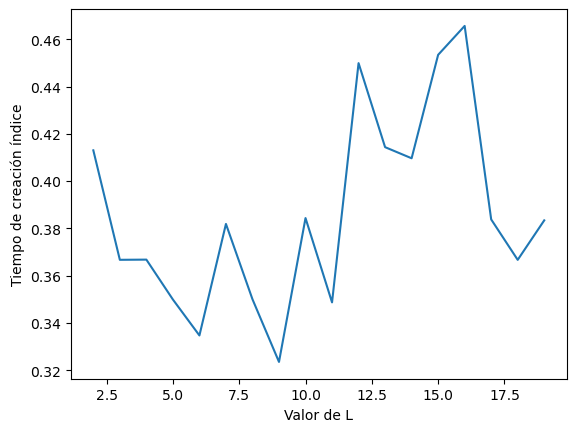

In [35]:
import time
import faiss
base = np.random.randint(0,10,(1000,5))
valores = []
tiempos = []
for i in range(2,20):
    inicio = time.time()
    index = HNSW(base, i, 1, 10, heuristic = True)
    fin = time.time()
    valores.append(i)
    tiempos.append(fin - inicio)
    
plt.xlabel('Valor de L')
plt.ylabel('Tiempo de creación índice')
plt.plot(valores, tiempos)


In [33]:
index_exact = faiss.IndexFlatL2(base.shape[1])
index_exact.add(base)
exact_dist, exact_ind = index_exact.search(q, 1) 

NameError: name 'q' is not defined

In [27]:
for _ in range(100000):
    d, i = index.search(q, 1)
exact_dist[0][0] / d[0][0]

1.0

In [109]:
np.min([euclidiana(q,b) for b in base]) - exact_dist[0][0]

NameError: name 'euclidiana' is not defined

In [ ]:
1 -((d[0][0] - np.min([euclidiana(q,b) for b in base])) / (np.min([euclidiana(q,b) for b in base]) + d[0][0]))

In [ ]:
q = np.random.randint(0, 10, 20).astype(float)
print(L)
euclidiana(vorazHNSW(hnsw, L, q), q), min([euclidiana(q, b) for b in base])

In [ ]:
np.min([euclidiana(q, u) for u in base])

In [ ]:
def RNG(base):
    rng = nx.Graph()
    for n, b in enumerate(base):
        rng.add_node(n, vector = b)
    for i, u in enumerate(base):
        for j, v in enumerate(base):
            if euclidiana(u,v) > 0:
                comp = np.all([euclidiana(u, v) < max(euclidiana(u, w), euclidiana(v, w)) for w in base if euclidiana(u, w) > 0 and euclidiana(v, w) > 0])
                if comp:
                    rng.add_edge(i, j)
    return rng

In [ ]:
rng = RNG(base)

In [ ]:
nx.draw(rng, with_labels=True, node_color='red', edge_color='gray')
plt.show()

In [ ]:
def alphaSNG(base, alpha = 1):
    sng = nx.DiGraph()
    edges = []
    for i, u in enumerate(base):
        sng.add_node(i, vector = u)
        distancias = sorted([(j, v, euclidiana(u, v)) for j, v in enumerate(base)], key = lambda x : x[2])[2:]
        while distancias:
            j = distancias[0][0]
            v = distancias[0][1]
            edges.append((i, j))
            distancias = sorted([(j, w, d) for j, w, d in distancias if euclidiana(u, w) < alpha * euclidiana(v, w)], key = lambda x : x[2])
    sng.add_edges_from(edges)
    return sng

In [ ]:
sng = alphaSNG(base)
nx.draw(sng, with_labels=True, node_color='red', edge_color='gray')
plt.show()

In [11]:
def Vamana(base, r, L, alpha):
    V = nx.random_regular_graph(d=r + 1, n=len(base))
    newEdges = []
    for i, b in enumerate(base):
        V.nodes[i]['vector'] = b
    for i, attr in V.nodes(data=True):
        u = attr['vector']
        visitados = voraz(V, u, L, np.random.randint(len(base)))[1]
        distancias = sorted([(j, attr['vector'], euclidiana(u, attr['vector'])) for j, attr in V.nodes(data=True) if j in visitados], key = lambda x : x[2])[2:]
        while distancias:
            j = distancias[0][0]
            v = distancias[0][1]
            newEdges.append((i, j))
            distancias = sorted([(j, w, d) for j, w, d in distancias if euclidiana(u, w) < alpha * euclidiana(v, w)], key = lambda x : x[2])
    V.add_edges_from(newEdges)
    return V

In [31]:
x = [1,2,3,4,5]
y = [5,1,8,3,2]
plt.plot(x,y)

: 

In [20]:
import time
import matplotlib.pyplot as plt
base = np.random.randint(0,10,(1000,5))
valores = []
tiempos = []
for i in range(1,3):
    inicio = time.time()
    vm = Vamana(base, 3, i, 1)
    fin = time.time()
    valores.append(i)
    tiempos.append(fin - inicio)
    
plt.xlabel('Valor de L')
plt.ylabel('Tiempo de creación índice')
plt.plot(valores, tiempos)

    

KeyboardInterrupt: 

In [12]:
base = np.random.randint(-5,5,(1000,5))
vm = Vamana(base, 3, 1, 1)

KeyboardInterrupt: 

In [11]:
q = np.random.randint(-10,0,2)
dist = euclidiana(voraz(vm,q,2,np.random.randint(0,len(vm.nodes())))[0][0], q)
dist

ValueError: operands could not be broadcast together with shapes (2,) (5,) 

In [72]:
iteraciones = 1000
error_medio = 0
q = np.random.randint(-10,0,50)
for _ in range(iteraciones):
#     q = np.random.randint(-500,500,50)
#     mindist = np.min([euclidiana(q, b) for b in base])
    dist = euclidiana(voraz(vm,q,2,np.random.randint(0,len(vm.nodes())))[0][0], q)
#     print(dist, mindist)
#     if dist == mindist:
#         error_medio += 1
#     else:
#         error_medio += (dist - mindist) / (dist + mindist)
# error_medio / iteraciones

In [41]:
def clustering(base, c):    
    centroids, _ = kmeans(base, c)
    clusters, _ = vq(base, centroids)
    return centroids, clusters

In [42]:
def consultaCluster(base, centroids, clusters, q, k):
    centroide = np.argmin([euclidiana(q, c) for c in centroids])
    return base[np.argpartition([euclidiana(q, v) for i, v in enumerate(base) if clusters[i] == centroide], k)][:k]

In [43]:
base = np.random.randint(0,5,(100,5))
centroids, clusters = clustering(base.astype(float), 3)
print(centroids,clusters)

[[2.20454545 1.63636364 3.15909091 1.84090909 2.06818182]
 [2.28571429 2.96428571 1.         3.14285714 3.46428571]
 [1.         1.57142857 0.64285714 1.46428571 1.28571429]] [1 0 2 0 2 1 2 2 0 2 1 0 1 0 2 0 1 1 2 0 2 2 1 0 0 1 0 0 0 0 0 0 2 0 2 0 0
 2 0 2 1 2 0 0 1 1 0 0 2 1 0 2 0 0 0 0 0 1 2 2 1 2 2 1 1 0 1 0 1 2 1 0 0 2
 0 0 2 0 0 1 2 1 1 0 2 2 0 0 0 2 0 0 1 1 0 2 1 1 1 1]


In [ ]:
def distribucionesMIPS(base):
    ptq = np.sum(base, axis=0)
    putq = []
    for u in base: 
        putq.append([u[t] / np.sum([base[:, t]]) for t in range(base.shape[1])])
    return ptq , np.array(putq)


In [ ]:
def muestreo(base, ptq, putq, q):
    ptq = q * ptq
    nptq = ptq / np.sum(ptq)
    dim = np.random.choice(np.arange(q.shape[0]), p=list(nptq))
    vector = np.random.choice(np.arange(putq.shape[0]), p=list(putq[:, dim]))
    return base[vector]


In [ ]:
ptq, putq = distribucionesMIPS(base)

In [ ]:
muestreo(base, ptq, putq, q)

In [ ]:
np.dot(muestreo(base, ptq, putq, q), q) - np.max([np.dot(v, q) for v in base])

In [ ]:
def sMuestreos(base, ptq, putq, q, s, kprima, k):
    cont = {}
    for i in range(s):
        v = muestreo(base, ptq, putq, q)
        if tuple(v) not in cont:
            cont[tuple(v)] = 1
        else:
            cont[tuple(v)] +=1
    topkprima = sorted([v for v in cont],  reverse=True, key = lambda x : cont[x])[:kprima]
    topk = sorted([np.array(v) for v in topkprima], reverse=True, key = lambda x : np.dot(np.array(v), q))[:k]
    return topk


In [ ]:
np.dot(q, sMuestreos(base, ptq, putq, q, 10000, 20, 5)[0]) - np.max([np.dot(q, v) for v in base]), np.dot(q, sMuestreos(base, ptq, putq, q, 10000, 20, 5)[0]) - np.min([np.dot(q, v) for v in base])

In [ ]:
def boundedME(q, k, base, epsilon, delta):
    X = base
    m, d = X.shape
    A = np.zeros(m)
    t = 0
    
    h = lambda x : np.min([1 + x / 1 + (x/d), x + (x/d) / 1 + (x/d)])
    while len(X) > k:
        numerador = 2 * (len(X) - k)
        denominador = delta * (np.floor((len(X) - k) / 2) + 1)
        ti = h((2 / epsilon**2) * np.log(numerador / denominador))
        for u in X: 
            J = np.random.choice(d, int(ti - t), replace=False)
            A[J] = A[J] + u[J] * q[J]
        alpha = sorted(A)[int(np.floor((len(X) - k) / 2))]
        indices = np.where(A > alpha)
        X = X[indices]
        epsilon *= 3 / 4
        delta /= 2
    return X

In [ ]:
def clustering(base, c):    
    centroids, _ = kmeans(base, c)
    clusters, _ = vq(base, centroids)
    return centroids, clusters

In [ ]:
def consultaCluster(base, centroids, clusters, q, k):
    centroide = np.argmin([euclidiana(q, c) for c in centroids])
    return base[np.argpartition([euclidiana(q, v) for i, v in enumerate(base) if clusters[i] == centroide], k)][:k]

In [77]:
def PQ(base, d0,c):
    d = base.shape[1]
    # A partir de aquí se define una matriz R tal que RR^T = I mediante factorización QR de una matriz aleatoria
    A = np.random.randn(d, d)
    Q, _ = np.linalg.qr(A.T)
    R = Q.T
    base = base @ R
    if d % d0 != 0:
        raise ValueError("La dimensión no es divisible entre d0")
    L = d // d0
    espacios = []
    for l in range(L):
        region = base[:,int(l*d0):int((l+1)*d0)]
        espacios.append(kmeans(region.astype(float),c)[0])
    return np.array(espacios)

In [78]:
def consultaPQ(espacios, q):
    d0 = espacios[0].shape[1]
    d = q.shape[0]
    L = d // d0
    resp = []
    for l in range(L):
        nc = espacios[l, np.argmin([euclidiana(e, q[int(l*d0):int((l+1)*d0)]) for e in espacios[l]])]
        for i in range(len(nc)):
            resp.append(nc[i])
    return np.array(resp)

In [86]:
def clustPQ(base, cen, cb, d0):
    centroides, clusters = clustering(base, cen)
    books = {}
    for i, _ in enumerate(centroides):
        books[i] = PQ(base[[j for j in range(base.shape[0]) if clusters[j] == i]], d0, cb)
    return centroides, books

In [220]:
def busquedaClustPq(q, centroides, books):
    b = np.argmin([euclidiana(q, c) for c in centroides])
    return consultaPQ(books[b], q)

In [248]:
def sketchingJL(base, d0):
    d = base.shape[1]
    phi = 1/np.sqrt(d0) * np.array([[1 if t > 0.5 else -1 for t in fila] for fila in  np.random.sample((d,d0))])
    return base @ phi

In [ ]:
base = np.random.randint(0,5,(100,50))
sketchingJL(base, 5).shape

In [ ]:
def asymetricSketching(u, h, d0):
    u_up, u_down = np.zeros(d0 // 2), np.zeros(d0 // 2)
    for k in range(d0 // 2):
        I = [i for i in nz(u) if any([pi_0(i) == k for pi_0 in h])]
        seleccionados = u[I]
        u_up[k] = np.max(seleccionados)
        u_down[k] = np.min(seleccionados)
    return nz(u), u_up, u_down

In [ ]:
def asymetricSketchingDistance(nz, u_up, u_down, q, h):
    s = 0
    for i in set(nz(q)) & set(nz):
        J = [pi_0(i) for pi_0 in h]
        if q[i] > 0:
            s += np.min(u_up[J])
        else:
            s += np.max(u_down[J])
    return s

In [ ]:
def samplingSketching(u, pi, d0):
    I, V = [], []
    norma = np.linalg.norm(u)
    for i in nz(u):
        theta = d0*(u[i] / norma)
        if pi(i) <= theta:
            I.append(i)
            V.append(u[i])
    return I, V, norma    

In [ ]:
def samplingSketchingDistance(su, sv, d0):
    Iu, Vu, norma_u = su
    Iv, Vv, norma_v = sv
    s = 0
    for i in set(Iu) & set(Iv):
        s += Vu[i]*Vv[i] / min(1, d0*Vu[i]**2/norma_u,d0*Vv[i]**2/norma_v)
    return s